Kobold Metals Assignment: Heat Map
==================================

Purpose: Explore the provided geodata and understand the materials provided for the assignment.
Before we begin:
- I know I'm being tested on project organization and coding practices.
- I want to have a minimal foundation, and get a working MVP at code that will generate a map.
- Depending on the time available, we may go further.

In [1]:
# Essential notebook imports and settings
%load_ext autoreload
%autoreload 2
%matplotlib inline

- There were code samples provided in the instructions PDF. Let's replicate that here.

In [10]:
import matplotlib.pyplot as plt

import geopandas as gpd
import numpy as np
from pathlib import Path

In [3]:
data_dir = Path("./materials/data/")

In [4]:
# Read the geodata files
bedrock_data = gpd.read_file(data_dir / "BedrockP.shp")

In [5]:
bedrock_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1596 entries, 0 to 1595
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   gid         1596 non-null   float64 
 1   upid        1596 non-null   object  
 2   area_m2     1596 non-null   float64 
 3   strat_unit  1596 non-null   object  
 4   era         1596 non-null   object  
 5   period      1596 non-null   object  
 6   strat_age   1596 non-null   object  
 7   strat_name  1184 non-null   object  
 8   gp_suite    1036 non-null   object  
 9   fm_lithodm  443 non-null    object  
 10  mem_phase   76 non-null     object  
 11  rock_class  1596 non-null   object  
 12  rock_type   1596 non-null   object  
 13  rk_char     2 non-null      object  
 14  unit_desc   1596 non-null   object  
 15  age_max     1596 non-null   object  
 16  age_min     1596 non-null   object  
 17  belt        1596 non-null   object  
 18  terrane     1596 non-null   object  
 19

In [6]:
bedrock_data.plot(column="era", categorical=True, legend=True, figsize=(20, 20))

<Axes: >

In [7]:
bedrock_data.era.value_counts()

era
Mesozoic                 803
Cenozoic                 375
Paleozoic-Mesozoic       143
Mesozoic-Cenozoic         84
Paleozoic                 83
Paleozoic to Mesozoic     62
Mesozoic to Cenozoic      34
Age Unknown               12
Name: count, dtype: int64

What do we see first?
- Mostly objects, mostly non-null columns
- src_url indicates data comes from multiple sources
- The data isn't massive -- only 1.5k geometry, though they are complex

Let's take a look at the task section again and orient ourselves around that.

We're asked to use a simple proximity heuristic for predicting the incidence of cobalt. There are two concrete requirements.
1. Write a software tool that creates a heatmap based on proximity to any two rock types. That proximity function should take a parmeter for "fall off distance"
1. The map deliverable should represent proximity to `serpentinite` and `granodiorite`. Note: For this dataset, `ultramafic` will be considered `serpentinite`.

What can we take from this?
- Write a command line tool that calls a function.
- That function should read the data and apply the heuristic with a fall off parameter, and two rock types.
- The data must be cleaned such that `ultramafic` is mapped to `serpentinite`.
- The resolution of the prediction is unspecified, though `~10km` is a suggested "fall off" distance.
- The exact distance function is left unspecified.

Let's get some ideas down before returnning to the README to create a task list and churning through for the afternoon.

- Command line tool
  - Create main.py with supporting utils module
  - On data loading, remap `ultramafic` to `serpentinite`
- "Likelihood" function
  - Some candidates
    - Sigmoid-like function
    - Exponential family
    - Kriging is based on guassian process, so maybe there's a guassian (also from exp family) that could work here?
- Point grid
  - It's a heat map, so how are we going to represent this?
    - Hex grids are the strong default, becuase they have desirable qualities for tiling the surface of the earth, and don't have the same diagonal chessboard problem, where the distance between adjacent tiles is one of two values, not just one.
    - Tile the plane with hexes

In [9]:
# Write prototype distance function and plot over distance from 0 to 3x the falloff distance
def likelihood_distance(distance, falloff_distance):
    return np.exp(-distance / falloff_distance)

fd = 1000
x_min = 0
x_max = 3 * fd
x = np.linspace(x_min, x_max, 1000)
y = likelihood_distance(x, fd)

plt.plot(x, y)

What did we learn?
- A guassian is exactly what we want
- We will modify this later to have a sharper cutoff, but this is okay for now.

What can we do about the grid and the map?
- I definitely want to add a transparent basemap to give a sense of localtion
- The reference heatmaps are continuous, so we should have something smooth like that.
- Spatial KDE over square grid?
- Computing the distance grid will be computationally expensive at low resolution, so we may need to spend some time speeding that up ... Well, we'll see, won't we.

What's in the data? What about rock types here? Let's see where these rocks are.

In [23]:
bedrock_data.rock_type.value_counts(dropna=False)

rock_type
undivided sedimentary rocks                                  246
undivided volcanic rocks                                     149
granodioritic intrusive rocks                                147
marine sedimentary and volcanic rocks                        146
basaltic volcanic rocks                                      141
dioritic intrusive rocks                                      96
coarse clastic sedimentary rocks                              79
quartz dioritic intrusive rocks                               72
ultramafic rocks                                              46
calc-alkaline volcanic rocks                                  44
serpentinite ultramafic rocks                                 42
high level quartz phyric, felsitic intrusive rocks            39
mudstone, siltstone, shale fine clastic sedimentary rocks     39
feldspar porphyritic intrusive rocks                          37
andesitic volcanic rocks                                      37
conglomerate, c

There's some extra data cleaning to be done here.
- The task document asks for serpentinite, granodiorite, and ultramafic rock, but the string literal `granodiorite` is not present.
- This is human readable, but not exact. This combines categories, and has redundant words like `rocks`.

What should we do about it?
- Check for word stems of a rock type.
- For now, simply rename.

<Axes: >

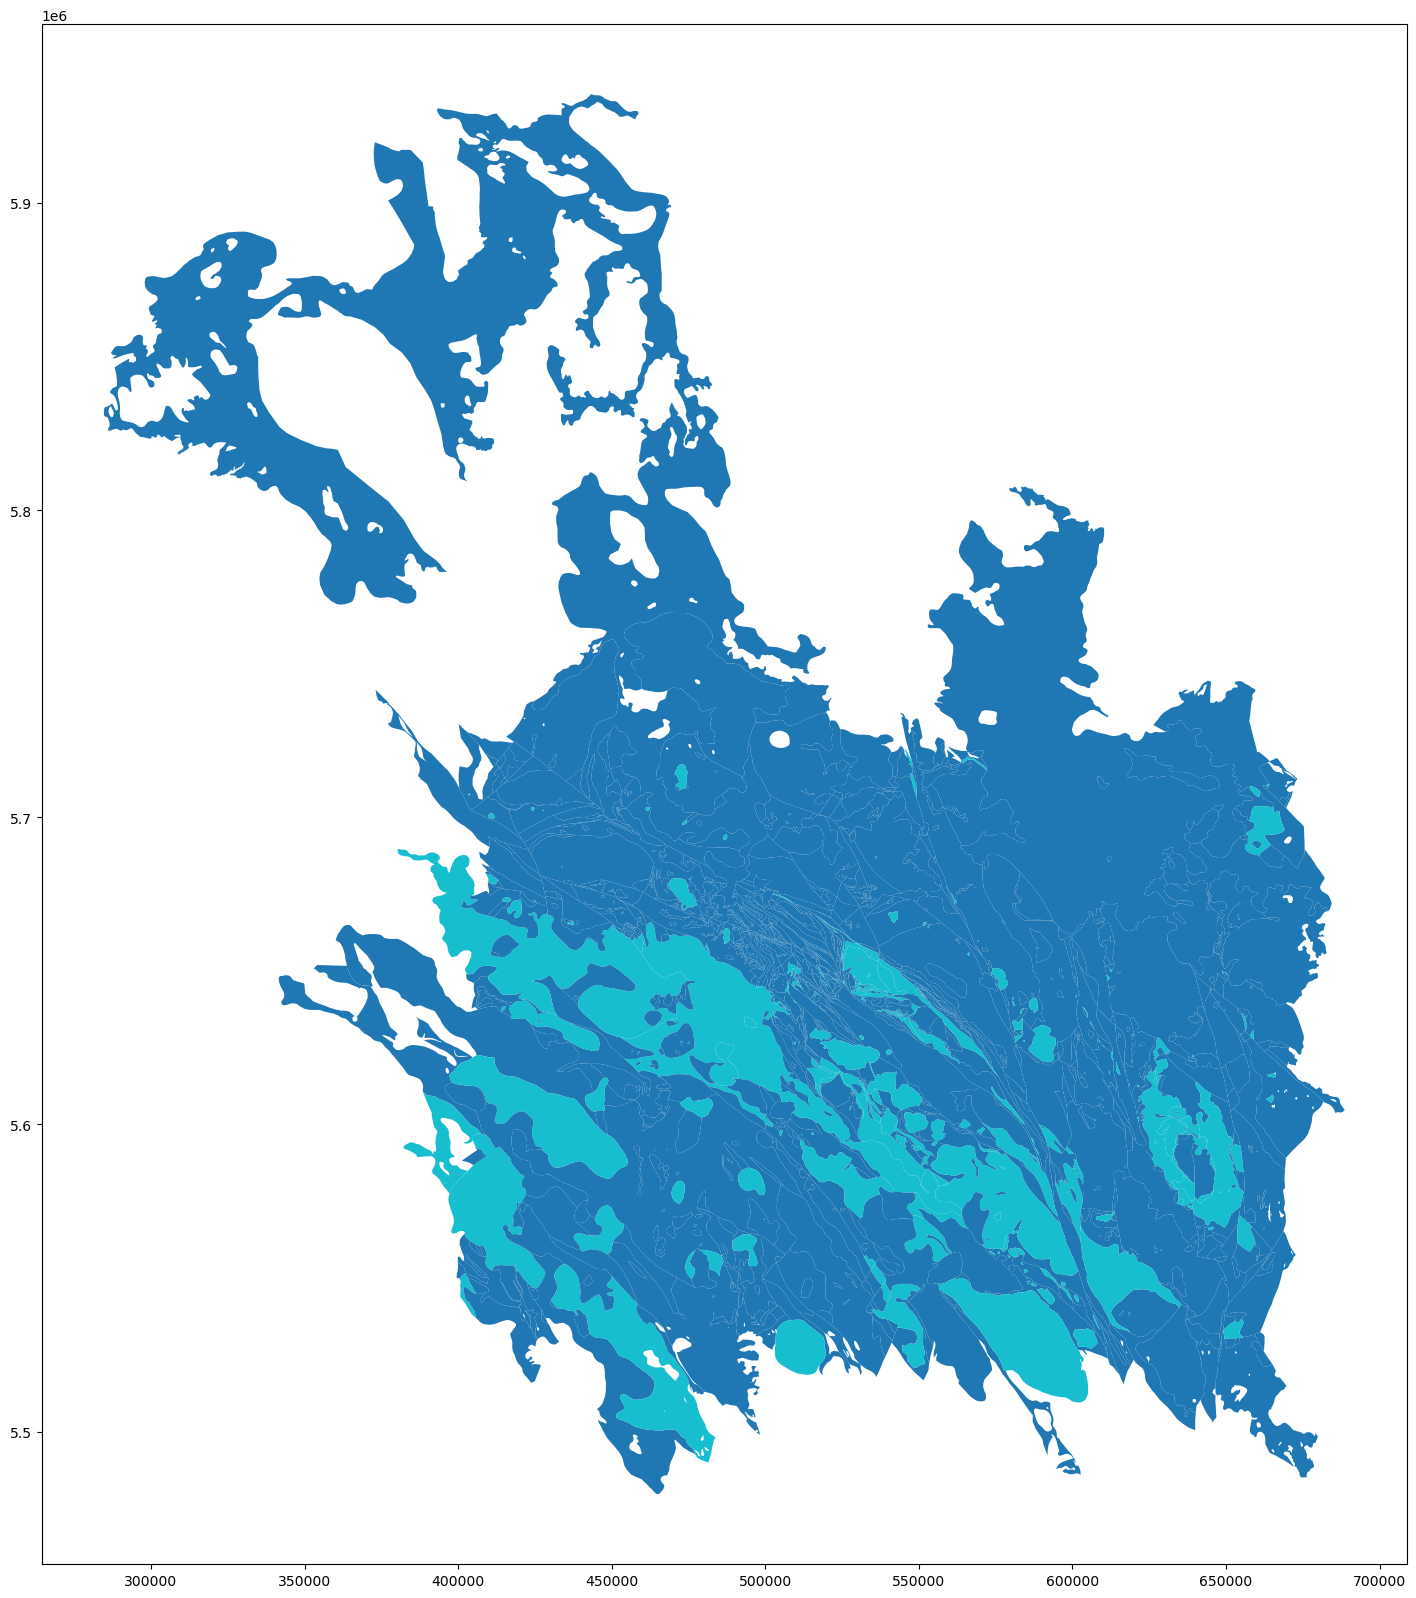

In [50]:
# Since the rock names don't exactly line up with instructions, we'll use the stems to find all occurences.
rock_type_stems = ["granodiorit", "ultramaf", "serpentinit"]
bedrock_data.assign(
    target=bedrock_data.rock_type.str.contains("|".join(rock_type_stems))
).plot(column="target", figsize=(20, 20))
